In [1]:
packages <- c(
  "tuneR",      # WAV file processing
  "seewave",    # WAV file processing
  "TSA",        # Periodograms
  "fda.usc",    # Functional data processing
  "mclust",     # Cluster metrics
  "funFEM",      # Clustering
  "funData",
  "dendextend"
)

for (package in packages) {
  if (!requireNamespace(package, quietly = TRUE)) {
    install.packages(package)
  }

  library(package, character.only = TRUE)
}

Warning message:
"package 'tuneR' was built under R version 4.3.3"
Warning message:
"package 'seewave' was built under R version 4.3.3"
Warning message:
"package 'TSA' was built under R version 4.3.3"

Attaching package: 'TSA'


The following object is masked from 'package:seewave':

    spec


The following object is masked from 'package:tuneR':

    periodogram


The following objects are masked from 'package:stats':

    acf, arima


The following object is masked from 'package:utils':

    tar


Warning message:
"package 'fda.usc' was built under R version 4.3.3"
Loading required package: fda

Warning message:
"package 'fda' was built under R version 4.3.3"
Loading required package: splines

Loading required package: fds

Warning message:
"package 'fds' was built under R version 4.3.3"
Loading required package: rainbow

Warning message:
"package 'rainbow' was built under R version 4.3.3"
Loading required package: MASS

Loading required package: pcaPP

Warning message:
"package 'pca

In [2]:
get_filepaths <- function(dir, subset) {
  return(file.path(dir, readLines(file.path(dir, subset))))
}

dataset_dir <- "SpeechCommands"
train_paths <- get_filepaths(dataset_dir, "train.txt")
val_paths <- get_filepaths(dataset_dir, "val.txt")
test_paths <- get_filepaths(dataset_dir, "test.txt")

In [3]:
load_audio_as_fdata <- function(filepath, func = mean) {
  audio <- tuneR::readWave(filepath)
  signal <- audio@left

  # Center the signal
  signal <- signal - mean(signal)

  pgram <- TSA::periodogram(signal, plot = FALSE)
  log_pgram <- log(pgram$spec + 1e-10)
  freqs <- pgram$freq * audio@samp.rate / 1000

  # Interpolate the log periodogram onto a coarser grid
  reduced_freqs <- seq(min(freqs), max(freqs), length.out = 512)
  log_pgram <- approx(x = freqs, y = log_pgram, xout = reduced_freqs)$y

  fdata_obj <- fda.usc::fdata(
    matrix(log_pgram, nrow = 1),
    argvals = reduced_freqs,
    rangeval = range(reduced_freqs),
    names = list(
      main = "Google Speech Commands",
      xlab = "Frequencies (kHz)",
      ylab = "log(Power)"
    )
  )

  return(fdata_obj)
}

load_dataset <- function(filepaths) {
  fdata_list <- list()
  labels <- c()

  for (filepath in filepaths) {
    # Extract class label from file path
    label <- strsplit(filepath, "/")[[1]][2]

    fdata_list[[filepath]] <- load_audio_as_fdata(filepath)
    labels <- c(labels, label)
  }

  # Convert list of fdata objects to single fdata object
  fdata <- do.call(c, fdata_list)

  # Convert class labels to factor
  labels <- factor(labels, levels = c(
    "zero", "one", "two", "three", "four",
    "five", "six", "seven", "eight", "nine"
  ))

  return(list(data = fdata, labels = labels))
}

train <- load_dataset(train_paths)
# val <- load_dataset(val_paths)
# test <- load_dataset(test_paths)

# Pick which dataset to visualize
dataset <- train

### Find optimal smoothing parames with B-Spline basis 

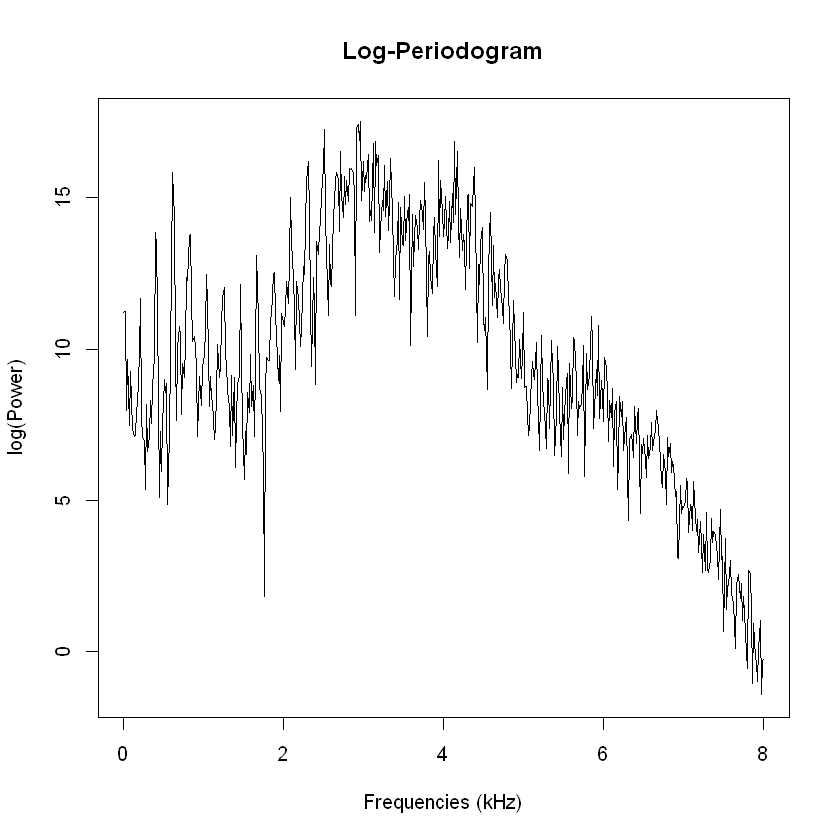

In [4]:
num_samples <- 1
plot(
  dataset$data[1:num_samples, ],
  main = "Log-Periodogram"
)

### Find optimal smoothing parames with Nadaraya-Watson

Optimal smoothing parameter: 0.03687551

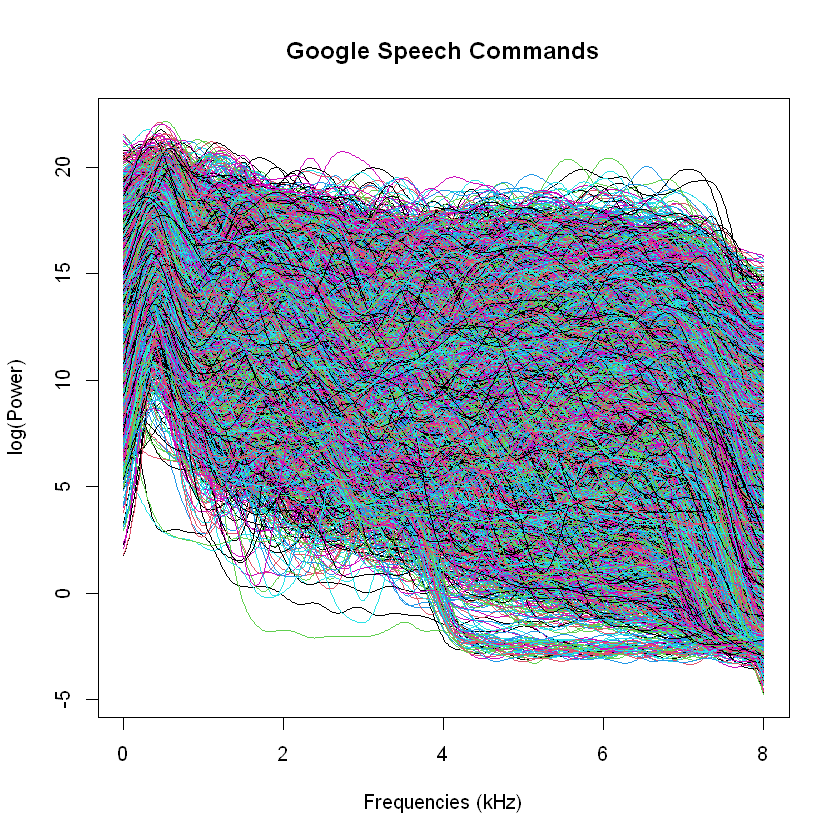

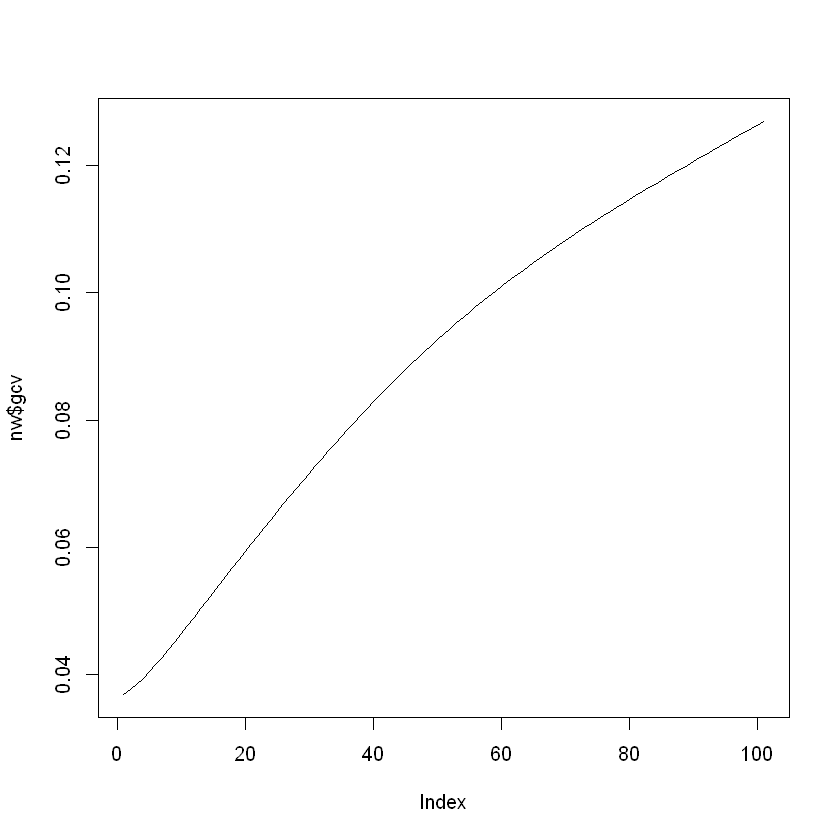

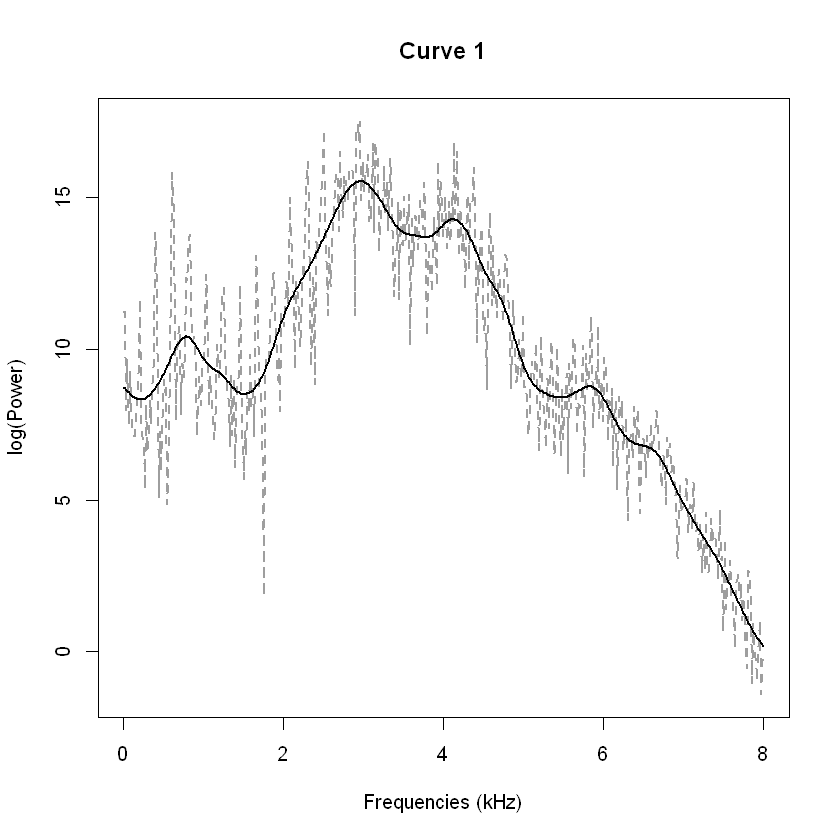

In [5]:
nw <- fda.usc::optim.np(
  dataset$data,
  type.S = S.NW,
  par.CV = list(criteria = "GCV")
)
cat("Optimal smoothing parameter:", nw$gcv.opt)

plot(nw$fdata.est)
plot(nw$gcv, type = "l")

index <- 1
plot(
  dataset$data[index, ],
  main = "Curve 1",
  lty = 2, lwd = 2, col = 8
)
lines(nw$fdata.est[index, ], col = 1, lty = 1, lwd = 2)

# Pick which kernel to use
dataset$kernel <- nw

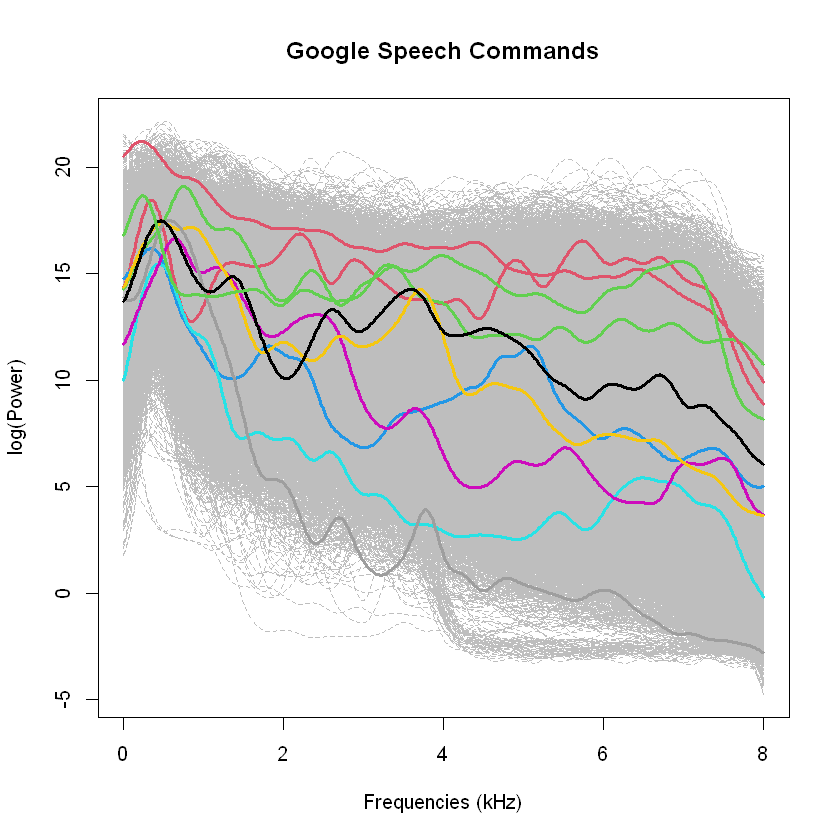

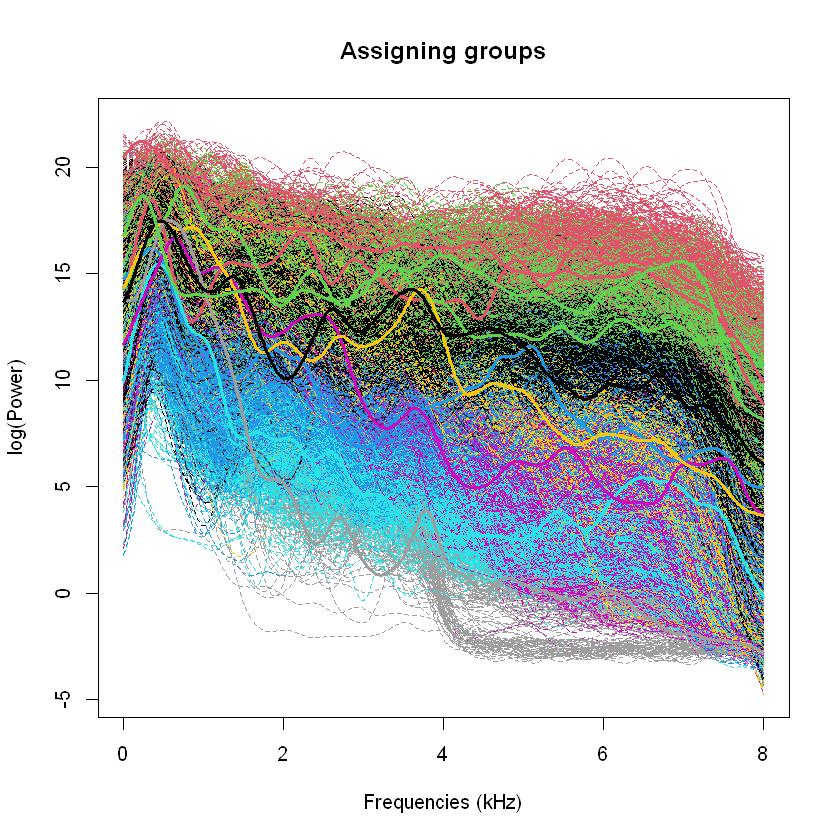

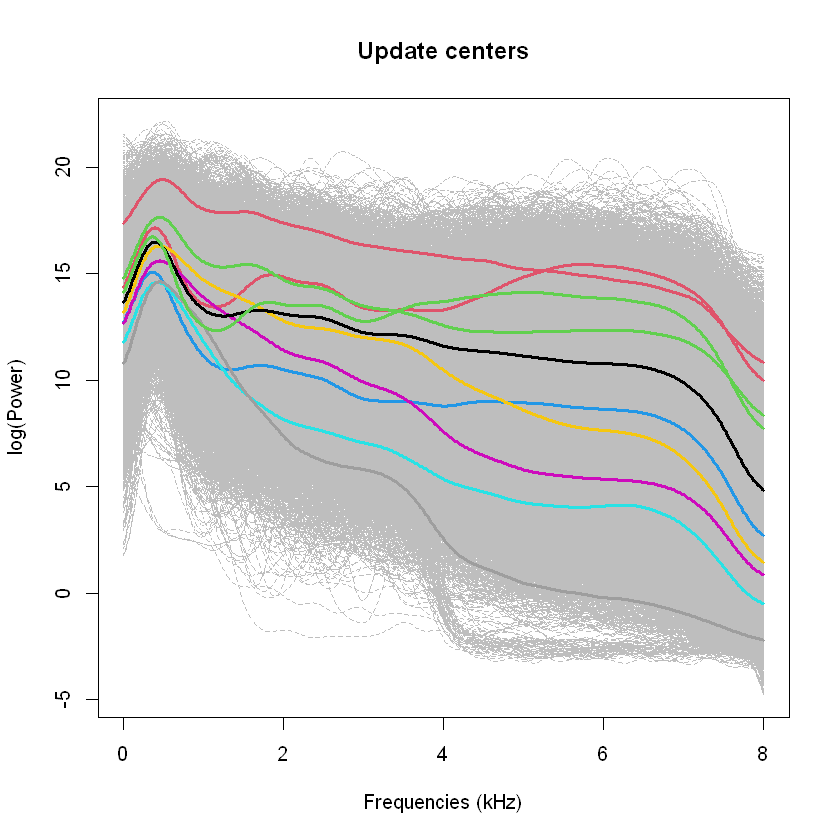

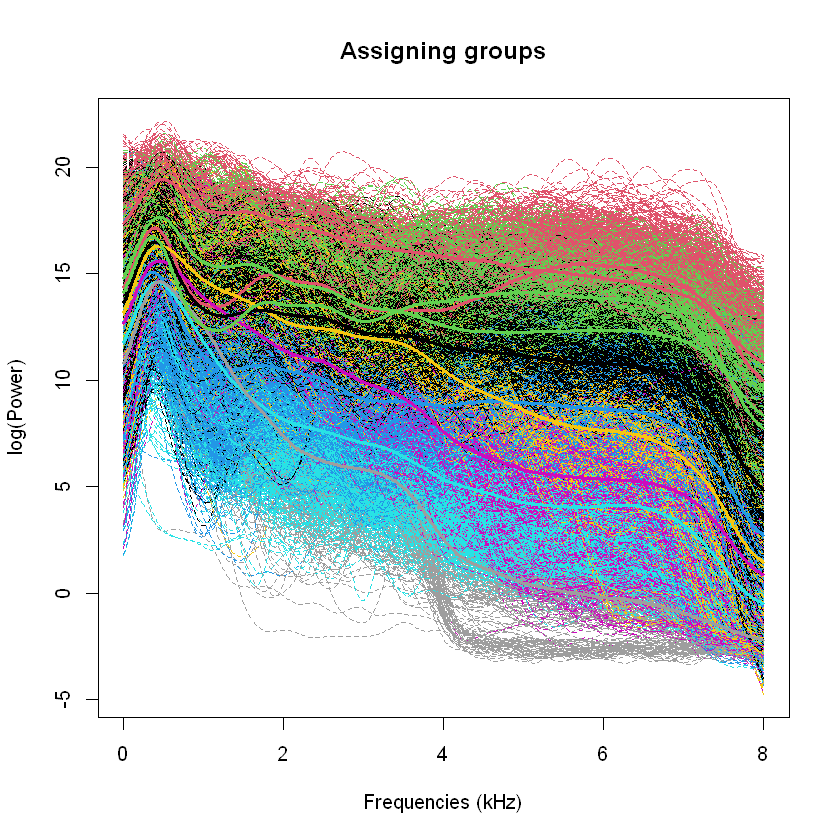

clusters
   1    2    3    4    5    6    7    8    9   10 
 717 1549 4871 1767 4225 6007  229 7258  229 1649 

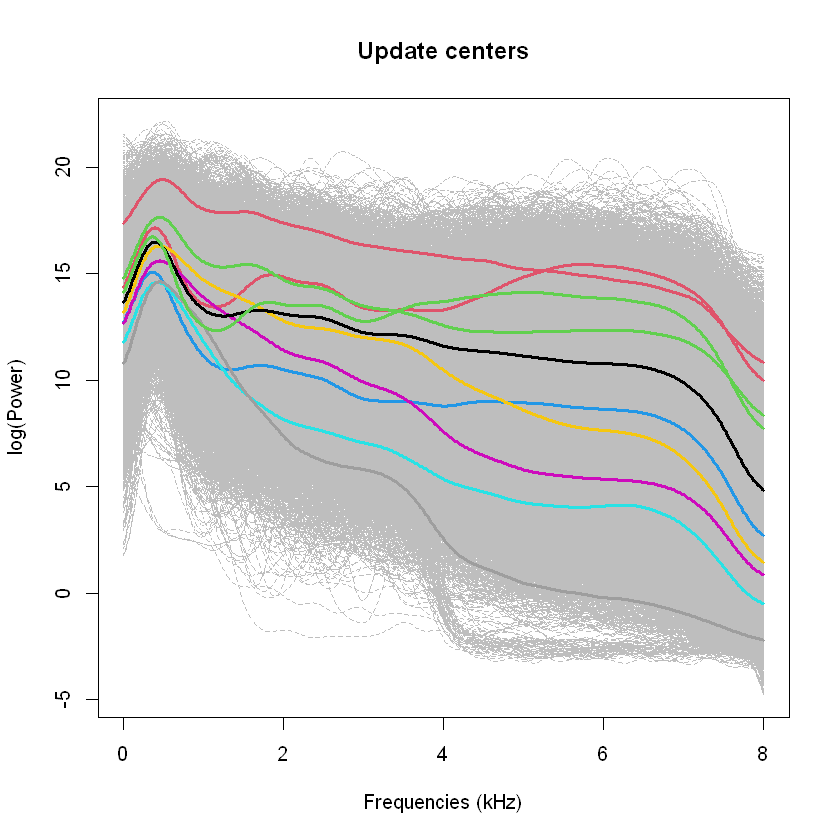

In [6]:
set.seed(123)

clust_result <- fda.usc::kmeans.fd(dataset$kernel$fdata.est, ncl = 10)

# Vector of cluster memberships (length = number of samples)
clusters <- clust_result$cluster
table(clusters)

In [7]:
table(True = dataset$labels, Cluster = clusters)

       Cluster
True       1    2    3    4    5    6    7    8    9   10
  zero    87  303  637   92  196  386   12 1074   36  196
  one      0   50  229  463  821  987   52  194   15    2
  two     46   79  792  141  192  330   11  967   14  253
  three   23  103  530  138  495  649   11  667   18   70
  four     1   88  613  503  543  472   85  358   18    7
  five     0  228  151   96  732 1138   17  585   30    5
  six    361  105  641   30   53   67    2  922   27  668
  seven  144  416  586   52  160  257    7 1029   31  259
  eight   51   57  557   82  202  509    5 1063   22  187
  nine     4  120  135  170  831 1212   27  399   18    2

In [8]:
adjustedRandIndex(dataset$labels, clusters)

# 1.0 → perfect match
# 0.0 → no better than random
# < 0 → worse than random (rare)

[1] 0.04622474

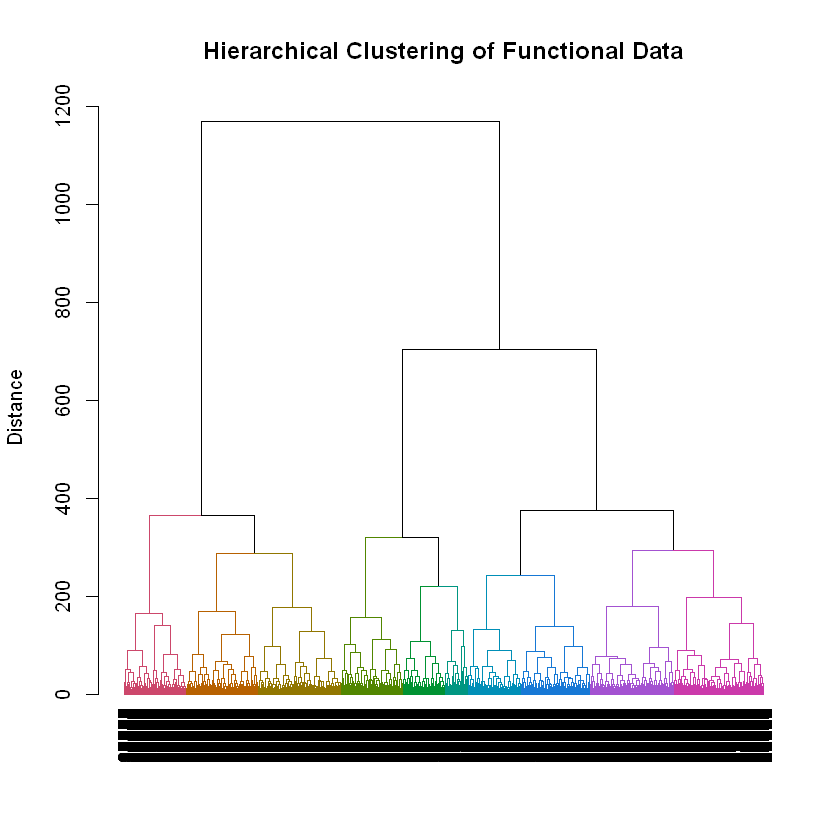

In [10]:
# Distance and clustering (already done by you)
dist_matrix <- metric.lp(dataset$kernel$fdata.est)
hc <- hclust(as.dist(dist_matrix), method = "ward.D2")

# Convert hclust to dendrogram
dend <- as.dendrogram(hc)

# Cut into 10 clusters (change k if you want)
k <- 10
clusters <- cutree(hc, k = k)

# Color the branches according to clusters
dend_colored <- color_branches(dend, k = k)

# Plot
plot(dend_colored, main = "Hierarchical Clustering of Functional Data", ylab = "Distance")

In [11]:
clusters_hc <- cutree(hc, k = 10)
table(True = dataset$labels, Cluster = clusters_hc)

       Cluster
True       1    2    3    4    5    6    7    8    9   10
  zero   129  285  395  590  333  524  102  400  207   54
  one    553  529   31  249  125    5  359   44  612  306
  two    156  148  802  188  350  446  194  302  182   57
  three  404  384  653  231  241  141  217  181  185   67
  four   151  233   28  319  406   41  493   65  715  237
  five   327  873   34  774  101   13  107  105  562   86
  six     42   35  408  138  220 1150   47  790   32   14
  seven  105  193  272  608  364  603   59  536  164   37
  eight  307  104 1266  133  157  260  145  295   49   19
  nine   581  932  105  476   75    6  138   66  392  147

In [12]:
adjustedRandIndex(dataset$labels, clusters_hc)

[1] 0.07631226

Warning message in fts(object$x, svdr[, , i]):
"Please assign column name for the data matrix."
Warning message in fts(object$x, svdr[, , i]):
"Please assign column name for the data matrix."
Warning message in fts(object$x, svdr[, , i]):
"Please assign column name for the data matrix."
Warning message in fts(object$x, svdrecon):
"Please assign column name for the data matrix."


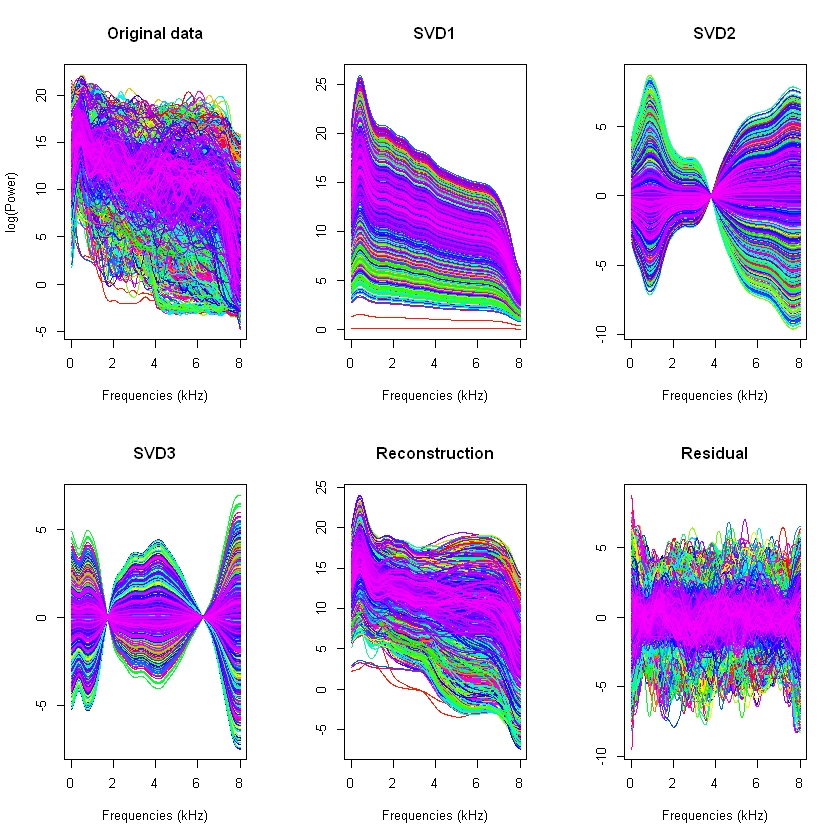

In [13]:
fd <- dataset$kernel$fdata.est
dataset$kernel$fds <- fds(
  x = fd$argvals,
  y = t(fd$data),
  xname = dataset$kernel$fdataobj$names$xlab,
  yname = dataset$kernel$fdataobj$names$ylab
)
SVDplot(dataset$kernel$fds, order = 3)